# Jupyter Notebook workflow

This tutorial builds a simple example in a jupyter notebook. This workflow is useful for interactive developement and rapid prototyping. 

### Load Hydra

Hydra is a configuration package that is built into the heart of Modulus Sym, which allows for easy control over various hyperparameters using YAML files. For every problem being solved using Modulus, Hydra is the first component to be initialized and has direct influence on all component levels inside of Modulus Sym.

Typically, if you are setting up the problem using a python script, this config file is loaded into a Python `ModulusConfig` object which is then used by Modulus. The below code shows a minimal python script that is ingesting the Modulus Sym configs.

```python
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.config import ModulusConfig

@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    print(to_yaml(cfg))

if __name__ == "__main__":
   run()
```

We recommend this workflow for larger more complex projects. This configuration setup is used in most of the examples documented in this User Guide. However, for running the Modulus Sym in a jupyter notebook environment, we can take the approach shown below which uses the `compose()` utility. Let's see how the config object can be loaded in such a case. The contents of the `config.yaml` file are shown:

```yaml
defaults :
  - modulus_default
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 200

save_filetypes : "vtk,npz"

training:
  rec_results_freq : 1000
  rec_constraint_freq: 1000
  max_steps : 10000
```

Next, we load the config file using:

In [1]:
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: 1000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch: ???
loss:
  _target_: modulus.loss.aggregator.Sum
  weights: null
optimizer:
  _params_:
    compute_gradients: adam_compute_gradients
    apply_gradients: adam_apply_gradients
  _target_: torch.optim.Adam
  lr: 0.001
  betas:
  

### Define the Geometry

For this puerly physics driven case, we won't use any external training data. Instead we will create some geometry that we can use to sample the various collocation points needed to impose the boundary and equation losses. Modulus Sym has several geometry objects to choose from ranging from 1D shapes like `Point1D`, `Line1D` to more complex 3D ones like `Torus`, `Tetrahedron` etc. Let's use the `Line1D` object for this example to sample the required points. 

In [2]:
from sympy import Symbol
from modulus.sym.geometry.primitives_1d import Line1D

# make geometry
x = Symbol("x")
geo = Line1D(0, 1)

Once the geometry object is instantiated, you can use methods like `sample_boundary` and `sample_interior` to sample the points using that geometry object to get a feel for what is being sampled. Feel free to plot the samples for more visualization. 

Boundary Samples {'x': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]]), 'normal_x': array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]]), 'area': array([[0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ]])}


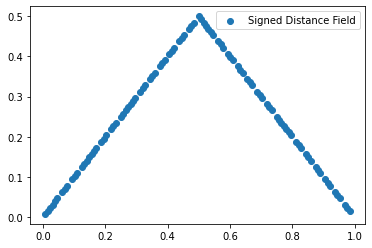

In [3]:
samples = geo.sample_boundary(10, quasirandom=True)
print("Boundary Samples", samples)

samples = geo.sample_interior(100, quasirandom=True)
# print("Interior Samples", samples)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(samples['x'], samples['sdf'], label='Signed Distance Field')
plt.legend()
plt.show()

### Create Nodes

In this section, we will create the nodes required for our problem. These include the neural network itself (which acts as a adaptable function) and any equations that are used to formulate the PDE loss functions. Before that, let's quickly define the differential equation for the problem using sympy. 

The `PDE` class allows us to write the equations symbolically in Sympy. This allows you to quickly write your equations in the most natural way possible. The Sympy equations are converted to PyTorch expressions in the back-end and can also be printed to ensure correct implementation.

In the subsequent examples we will look at how to code a more complicated PDE, but for this example, the simple PDE can be set up as below. Modulus Sym also comes with several common PDEs predefined for the user to choose from. Some of the PDEs that are already available in the PDEs module are: Navier Stokes, Linear Elasticity, Advection Diffusion, Wave Equations, etc.

In [4]:
from sympy import Symbol, Number, Function
from modulus.sym.eq.pde import PDE

class CustomPDE(PDE):
    def __init__(self, f=1.0):
        # coordinates
        x = Symbol("x")

        # make input variables
        input_variables = {"x": x}

        # make u function
        u = Function("u")(*input_variables)

        # source term
        if type(f) is str:
            f = Function(f)(*input_variables)
        elif type(f) in [float, int]:
            f = Number(f)

        # set equations
        self.equations = {}
        self.equations["custom_pde"] = (
            u.diff(x, 2) - f
        )  # "custom_pde" key name will be used in constraints

Now that we have the custom PDE defined, let's setup the nodes for the problem. 

In [5]:
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.key import Key

# make list of nodes to unroll graph on
eq = CustomPDE(f=1.0)
u_net = FullyConnectedArch(
    input_keys=[Key("x")], output_keys=[Key("u")], nr_layers=3, layer_size=32
)

nodes = eq.make_nodes() + [u_net.make_node(name="u_network")]

Let's visualize the symbolic node that we created and the architecture itself.

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=32, bias=True)
      )
      (1): FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
      (2): FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
    )
    (final_layer): FCLayer(
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
custom_pde: u__x__x - 1.0
None
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


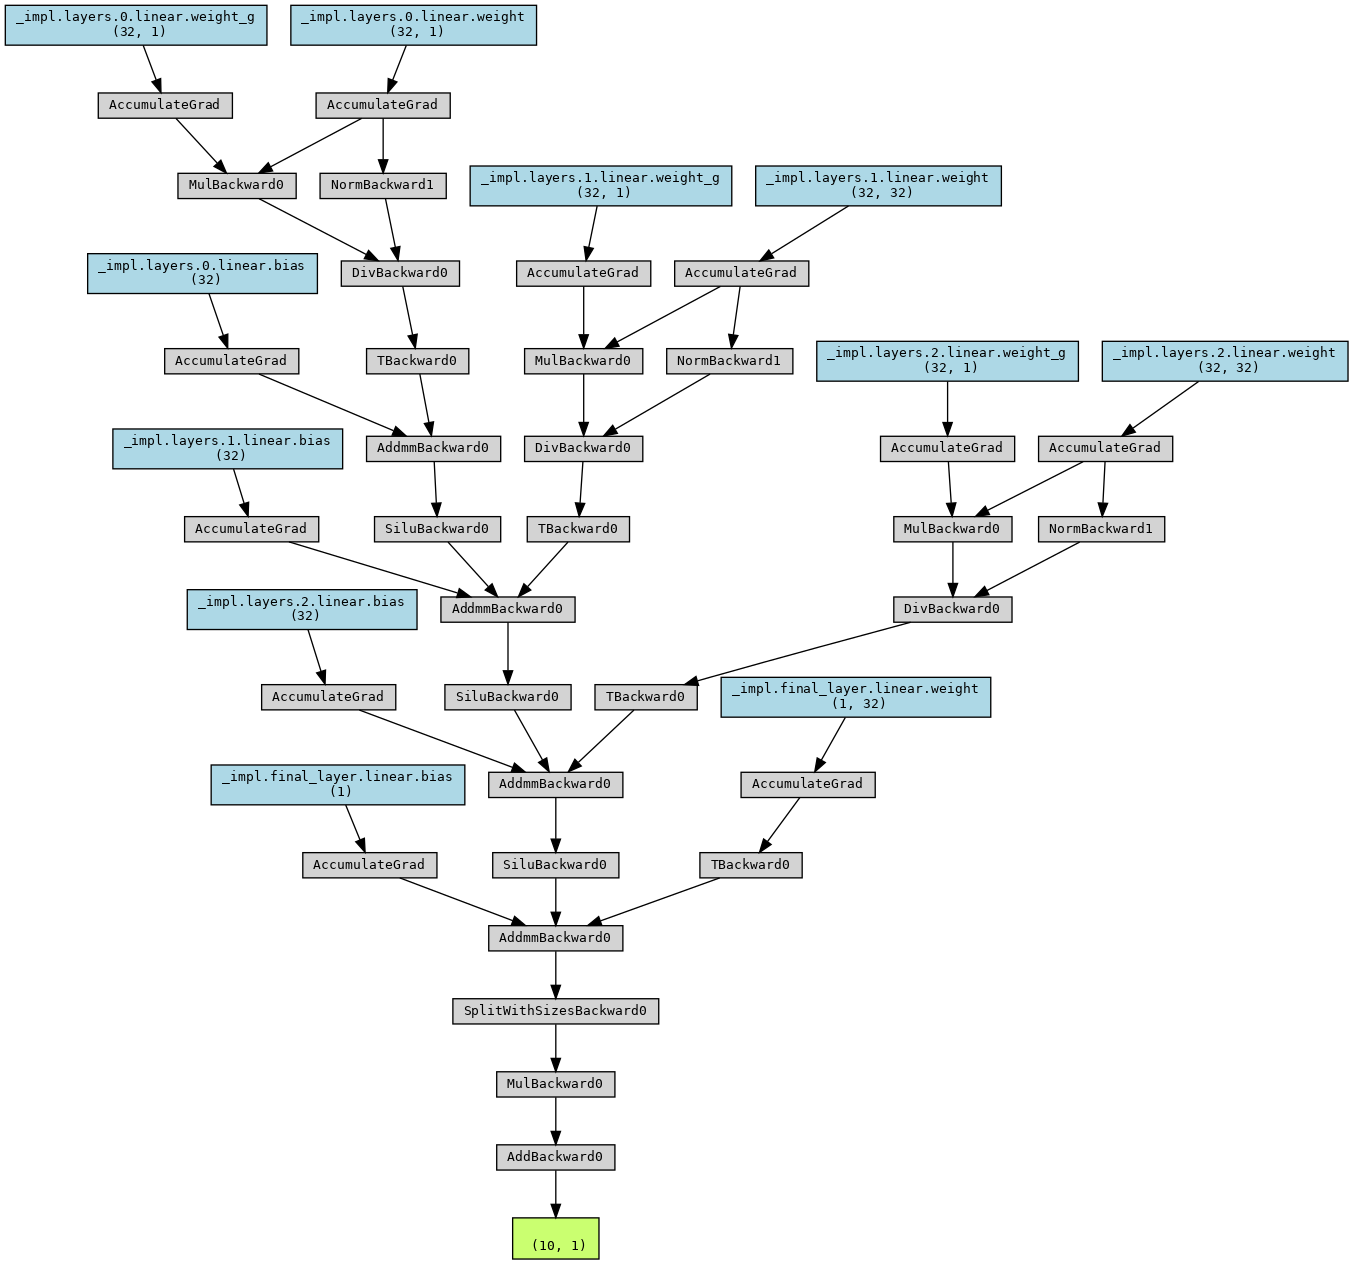

In [6]:
# visualize the network and symbolic equation in Modulus Sym:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
!pip install torchviz
import torch
from torchviz import make_dot
from IPython.display import Image 
    
# pass dummy data through the model 
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

### Create Domain and add constraints

The ``Domain`` holds all constraints as well as additional components needed in the training process.  These additional components include inferencers, validators, and monitors. When developing in Modulus Sym, constraints that the user defines are then added to the training ``Domain`` to create a collection of training objectives. The Domain and the configs are passed as inputs when using the Solver class. 

In [7]:
from modulus.sym.domain import Domain

# make domain
domain = Domain()

Now let’s look into adding constraints to this domain. This can be thought of as adding specific constraints to the neural network optimization. For this physics-driven problem, these constraints are the boundary conditions and equation residuals. The goal is to satisfy the boundary conditions exactly, and ideally have the PDE residuals to go 0. These constraints can be specified within Modulus Sym using classes like `PointwiseBoundaryConstrant` and `PointwiseInteriorConstraint`. A L2 loss (defult and can be modified) is then constructed from these constraints which is used by the optimizer to minimize on. Specifying the constraints in this fashion is called soft-constraints.

**Boundary constraints:** For generating a boundary condition, we need to sample the points on the required boundary/surface of the geometry, specify the nodes we would like to unroll/evaluate on these points and then assign them the desired values.

A boundary can be sampled using `PointwiseBoundaryConstraint` class. This will sample the entire boundary of the geometry we specify in the geometry argument, in this case, both the endpoints of the 1d line. A particular boundary of the geometry can be sub-sampled by using a particular criterion using the `criteria` parameter. We will see its use in a later example. The desired values for the boundary condition are listed as a dictionary in outvar argument. These dictionaries are then used when unrolling the computational graph (specified using the nodes argument) for training. The number of points to sample on each boundary are specified using the `batch_size` argument.

**Equations to solve:** The Custom PDE we defined is enforced on all the points in the interior. We will use `PointwiseInteriorConstraint` class to sample points in the interior of the geometry. Again, the appropriate geometry is specified in the geometry argument; the equations to solve are specified as a dictionary input to outvar argument. These dictionaries are then used when unrolling the computational graph (specified using the nodes argument) for training. For this problem we have the `'custom_pde':0`. The argument `bounds`, determines the range for sampling the values for variables. 

In [8]:
from modulus.sym.domain.constraint import PointwiseBoundaryConstraint, PointwiseInteriorConstraint

# bcs
bc = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=2,
)
domain.add_constraint(bc, "bc")

# interior
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"custom_pde": 0},
    batch_size=100,
    bounds={x: (0, 1)},
)
domain.add_constraint(interior, "interior")

### Create any inferencers, validators or monitors

Let's create some inferencer object to visualize our results. 

In [9]:
import numpy as np
from modulus.sym.domain.inferencer import PointwiseInferencer

# add inferencer
inference = PointwiseInferencer(
    nodes=nodes,
    invar={"x": np.linspace(0, 1.0, 100).reshape(-1,1)},
    output_names=["u"],
)
domain.add_inferencer(inference, "inf_data")

### Put everything together: Solver and training

We can create a solver by using the domain we just created along with the other configurations that define the optimizer choices, settings (i.e. `conf`) using Modulus Sym’s `Solver` class. The solver can then be executed using the solve method. 

In [10]:
# to make the logging work in the jupyter cells
# execute this cell only once
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [11]:
import os
from modulus.sym.solver import Solver

# optional 
# set appropriate GPU in case of multi-GPU machine
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

# make solver
slv = Solver(cfg, domain)

# start solver
slv.solve()

attempting to restore from: /examples/workspace_0.5/modulus_documentation/modulus/docs/user_guide/notebook/outputs
Success loading optimizer: /examples/workspace_0.5/modulus_documentation/modulus/docs/user_guide/notebook/outputs/optim_checkpoint.pth
Success loading model: /examples/workspace_0.5/modulus_documentation/modulus/docs/user_guide/notebook/outputs/u_network.pth
[step:      10000] saved constraint results to outputs
[step:      10000] record constraint batch time:  8.691e-01s
[step:      10000] saved inferencer results to outputs
[step:      10000] record inferencers time:  4.079e-03s
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
[step:      10000] saved checkpoint to /examples/workspace_0.5/m

### Visualizing the results

The inference domain can be visulaized and the results can be plotted using `matplotlib`. 

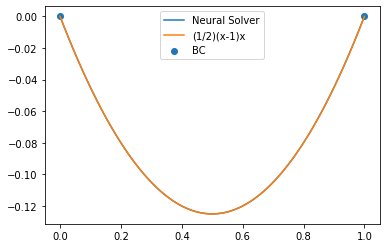

In [12]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load('./outputs/inferencers/inf_data.npz', allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]
plt.figure()
x = data['x'].flatten()
pred_u = data['u'].flatten()
plt.plot(np.sort(x), pred_u[np.argsort(x)], label='Neural Solver')
plt.plot(np.sort(x), 0.5*(np.sort(x)*(np.sort(x)-1)), label='(1/2)(x-1)x')
x_np = np.array([0., 1.])
u_np = 0.5*(x_np-1)*x_np
plt.scatter(x_np, u_np, label='BC')
plt.legend()
plt.show()